<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/OverKill_S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])



In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)




CUDA Available? False


In [0]:
# Scratch Model
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # Conv Block1 
      self.convblock1 = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = (3,3), padding = 0, bias = False), 
          nn.ReLU(),
          nn.BatchNorm2d(10)) # O/P: 26
      
      # Conv Block2
      self.convblock2 = nn.Sequential(
          nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(10)) # O/P: 24
      

      # MaxPool Layer
      self.maxpool = nn.Sequential(nn.MaxPool2d((2,2))) # O/P: 12

      # ConvBlock 3
      self.convblock3 = nn.Sequential(
          nn.Conv2d(in_channels = 10, out_channels = 16, kernel_size = (1,1), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 12
      
      
      # ConvBlock 4
      self.convblock4 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 10
      
      # ConvBlock 5
      self.convblock5 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # O/P: 8

      # ConvBlock 6
      self.convblock6 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 10, kernel_size = (1,1), padding = 0,  bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(10)) # O/P: 8


    # ConvBlock 7
      self.convblock7 = nn.Sequential(
          nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = (3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(10)) # O/P: 6


    # # ConvBlock 8
    #   self.convblock8 = nn.Sequential(
    #       nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding = 0, bias = False),
    #       nn.ReLU(),
    #       nn.BatchNorm2d(16)) # O/P: 6
    

    # GAP
      self.gap = nn.Sequential(nn.AvgPool2d(6))

    
    # Last Layer
      self.convblock8 = nn.Sequential(
          nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = (1,1), padding = 0, bias = False))


    # Dropout Layer
      self.drop = nn.Sequential(nn.Dropout(0.1))



    def forward(self,x):
      x = self.convblock1(x)
      x = self.drop(x)
      x = self.convblock2(x)
      x = self.drop(x)
      x = self.maxpool(x)
      x = self.convblock3(x)
      x = self.drop(x)
      x = self.convblock4(x)
      x = self.drop(x)
      x = self.convblock5(x)
      x = self.drop(x)
      x = self.convblock6(x)
      # x = self.drop(x)
      x = self.convblock7(x)
      x = self.gap(x)
      x = self.convblock8(x)
     
      x = x.view(-1, 10)
      return F.log_softmax(x, dim = -1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 16, 12, 12]             160
             ReLU-11           [-1, 16, 12, 12]               0
      BatchNorm2d-12           [-1, 16, 12, 12]              32
          Dropout-13           [-1, 16, 12, 12]               0
           Conv2d-14           [-1,

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_acc_epoch = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    # in view() method the shape of the desired output tensor is to be passed in as the parameter,
    # whereas in view_as() a tensor whose shape is to be mimicked it passed.
    # tensor.view_as(other) is equivalent to tensor.view(other.size())
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    if batch_idx == 468:
      train_acc_epoch.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))


In [9]:
# Optimization and Testing
from torch.optim.lr_scheduler import CyclicLR


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = ReduceLROnPlateau(optimizer, 'min')
# scheduler = CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)
scheduler = StepLR(optimizer, step_size=4, gamma=0.5) # Consistent with 99.3% Accuracy


for epoch in range(1, 10):
    print('EPOCH: ',epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)



  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:  1


Loss=0.23531551659107208 Batch_id=468 Train Accuracy=81.30: 100%|██████████| 469/469 [01:15<00:00,  6.20it/s]
Loss=0.15554283559322357 Batch_id=0 Train Accuracy=96.09:   0%|          | 1/469 [00:00<01:13,  6.34it/s]


Test set: Average loss: 0.1632, Test Accuracy: 9563/10000 (95.63%)

EPOCH:  2


Loss=0.1123400554060936 Batch_id=468 Train Accuracy=96.31: 100%|██████████| 469/469 [01:14<00:00,  6.27it/s]
Loss=0.059142451733350754 Batch_id=0 Train Accuracy=97.66:   0%|          | 1/469 [00:00<01:18,  5.93it/s]


Test set: Average loss: 0.0629, Test Accuracy: 9823/10000 (98.23%)

EPOCH:  3


Loss=0.029324034228920937 Batch_id=468 Train Accuracy=97.06: 100%|██████████| 469/469 [01:14<00:00,  6.26it/s]
Loss=0.08371467888355255 Batch_id=0 Train Accuracy=97.66:   0%|          | 1/469 [00:00<01:19,  5.87it/s]


Test set: Average loss: 0.0476, Test Accuracy: 9856/10000 (98.56%)

EPOCH:  4


Loss=0.09934893995523453 Batch_id=468 Train Accuracy=97.50: 100%|██████████| 469/469 [01:15<00:00,  6.24it/s]
Loss=0.10319016128778458 Batch_id=0 Train Accuracy=96.88:   0%|          | 1/469 [00:00<01:20,  5.81it/s]


Test set: Average loss: 0.0437, Test Accuracy: 9867/10000 (98.67%)

EPOCH:  5


Loss=0.044732045382261276 Batch_id=468 Train Accuracy=97.82: 100%|██████████| 469/469 [01:15<00:00,  6.19it/s]
Loss=0.07623560726642609 Batch_id=0 Train Accuracy=97.66:   0%|          | 1/469 [00:00<01:17,  6.07it/s]


Test set: Average loss: 0.0526, Test Accuracy: 9838/10000 (98.38%)

EPOCH:  6


Loss=0.032031863927841187 Batch_id=468 Train Accuracy=97.96: 100%|██████████| 469/469 [01:21<00:00,  5.78it/s]
Loss=0.08569233864545822 Batch_id=0 Train Accuracy=97.66:   0%|          | 1/469 [00:00<01:20,  5.78it/s]


Test set: Average loss: 0.0374, Test Accuracy: 9881/10000 (98.81%)

EPOCH:  7


Loss=0.10824111849069595 Batch_id=468 Train Accuracy=98.11: 100%|██████████| 469/469 [01:18<00:00,  5.99it/s]
Loss=0.09767599403858185 Batch_id=0 Train Accuracy=97.66:   0%|          | 1/469 [00:00<01:25,  5.49it/s]


Test set: Average loss: 0.0319, Test Accuracy: 9914/10000 (99.14%)

EPOCH:  8


Loss=0.10039296746253967 Batch_id=468 Train Accuracy=98.20: 100%|██████████| 469/469 [01:17<00:00,  6.05it/s]
Loss=0.040913231670856476 Batch_id=0 Train Accuracy=99.22:   0%|          | 1/469 [00:00<01:19,  5.92it/s]


Test set: Average loss: 0.0341, Test Accuracy: 9888/10000 (98.88%)

EPOCH:  9


Loss=0.027677765116095543 Batch_id=468 Train Accuracy=98.33: 100%|██████████| 469/469 [01:17<00:00,  6.08it/s]



Test set: Average loss: 0.0312, Test Accuracy: 9894/10000 (98.94%)



Text(0.5, 1.0, 'Test Accuracy')

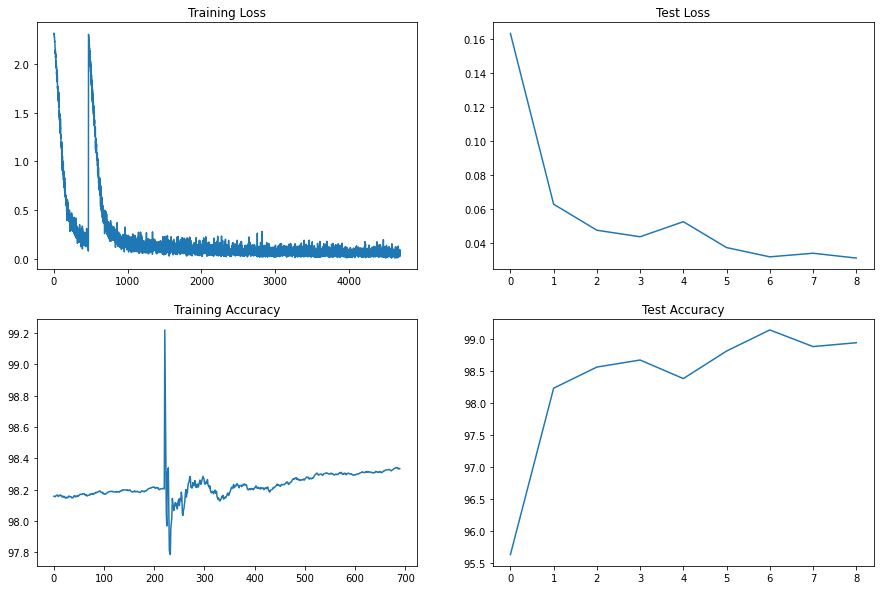

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")